Example of using Orbit Fitter class.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pyarrow.compute as pc
from pathlib import Path

from adam_assist import ASSISTPropagator
from adam_core.orbits.orbits import Orbits
from adam_core.orbit_determination import evaluate_orbits, mpc_to_od_observations
from mpcq import MPCObservations
from mpcq.orbits import MPCOrbits

from adam_core.orbit_determination import FindOrbOrbitFitter, OrbitDeterminationObservations, FittedOrbitMembers, FittedOrbits


/workspaces/adam_core/.venv/lib/python3.11/site-packages/assist/__init__.py:44: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
data_dir = Path("../data/orbit_fit_eval")
mpc_observations = MPCObservations.from_parquet(data_dir / "mpc_observations.parquet").sort_by([("obstime", "ascending")])
mpc_orbits = MPCOrbits.from_parquet(data_dir / "mpc_orbits.parquet")
sbdb_orbits = Orbits.from_parquet(data_dir / "sbdb_orbits.parquet")
neocc_orbits = Orbits.from_parquet(data_dir / "neocc_orbits.parquet")

In [ ]:
# Evaluation helpers
def print_orbit_get_chi2(message: str, orbit: Orbits, observations: OrbitDeterminationObservations, propagator=ASSISTPropagator()):
    if len(orbit) == 0:
        return None
    comm = orbit.coordinates.to_cometary()
    fit_orbit, fit_members = evaluate_orbits(orbit, observations, propagator)
    rchi2, residuals = fit_orbit.reduced_chi2[0], fit_members.residuals
    chi2 = residuals.chi2.to_numpy()
    np.set_printoptions(precision=3)
    print(f"{message}, object {orbit.object_id.to_pylist()}, orbit {orbit.orbit_id.to_pylist()}, rchi2={rchi2}\n"
          f"q={comm.q.to_pylist()[0]} e={comm.e.to_pylist()[0]} i={comm.i.to_pylist()[0]}\n"
          f"raan={comm.raan.to_pylist()[0]} ap={comm.ap.to_pylist()[0]} tp={comm.tp.to_pylist()[0]}\n"
          f"time={comm.time.to_iso8601().to_pylist()[0]} ({comm.time.mjd()[0]} MJD)"
          f" period={comm.P[0]} origin={comm.origin.code.to_pylist()[0]}\n"
          f"{comm.covariance.to_matrix()[0]}")
    return chi2

def show_for(object_id: str, od_observations: OrbitDeterminationObservations, 
             fitted_orbits: FittedOrbits, fitted_members: FittedOrbitMembers, obsids) -> None:
    _, ax = plt.subplots(figsize=(15, 6))

    res=print_orbit_get_chi2("MPC orbit", mpc_orbits.apply_mask(pc.equal(mpc_orbits.requested_provid, object_id)).orbits(), od_observations)
    if res is not None:
        ax.plot(res, label="MPC")
    res=print_orbit_get_chi2("SBDB orbit", sbdb_orbits.apply_mask(pc.match_substring(sbdb_orbits.object_id, object_id)), od_observations)
    if res is not None:
        ax.plot(res, label="SBDB")
    res=print_orbit_get_chi2("NEOCC orbit", neocc_orbits.apply_mask(pc.equal(neocc_orbits.object_id, object_id.replace(" ", ""))), od_observations)
    if res is not None:
        ax.plot(res, label="NEOCC")
    res=print_orbit_get_chi2("Fitted orbit", fitted_orbits.apply_mask(pc.equal(fitted_orbits.object_id, object_id)), od_observations)
    if res is not None:
        # Mark observations rejected by the fitter
        outliers = fitted_members.apply_mask(pc.is_in(fitted_members.obs_id, obsids)).outlier
        ax.plot(res, markevery=outliers, marker='x', label="Fitted")
    ax.legend(loc='upper right')
    ax.set_title(f"Object {object_id}")

    plt.show()

MPC orbit, object ['1999 RQ36'], orbit ['675043'], rchi2=64.9268031073047
q=0.8965906401930089 e=0.20373108132691006 i=6.032903980111988
raan=1.9724128110889805 ap=66.39437769115736 tp=60675.7378717287
time=2025-05-05T00:00:00.000 (60800.0 MJD) period=436.415414911677 origin=SUN
[[ 8.354e-17  6.264e-31 -2.182e-29  5.126e-29  2.217e-28  1.770e-28]
 [ 2.400e-31  6.681e-17 -1.607e-29 -4.517e-29 -1.157e-28 -1.438e-28]
 [-2.083e-29 -1.630e-29  1.511e-12 -5.357e-26  6.464e-27 -5.123e-28]
 [ 6.489e-29 -8.271e-30 -5.421e-26  6.533e-12 -3.306e-27  3.740e-27]
 [ 2.110e-28 -1.741e-28  6.238e-27 -1.053e-26  9.245e-12 -1.652e-26]
 [ 6.826e-29 -7.246e-29 -5.200e-28  6.138e-27 -2.012e-27  3.645e-12]]
SBDB orbit, object ['101955 Bennu (1999 RQ36)'], orbit ['00001'], rchi2=75.090369440982
q=0.8968944004459735 e=0.2037450762416413 i=6.034943770247886
raan=2.060866195696442 ap=66.22306084084302 tp=55438.64194087265
time=2011-01-01T00:00:00.000 (55562.0 MJD) period=436.64872811310624 origin=SUN
[[ 5.312e-

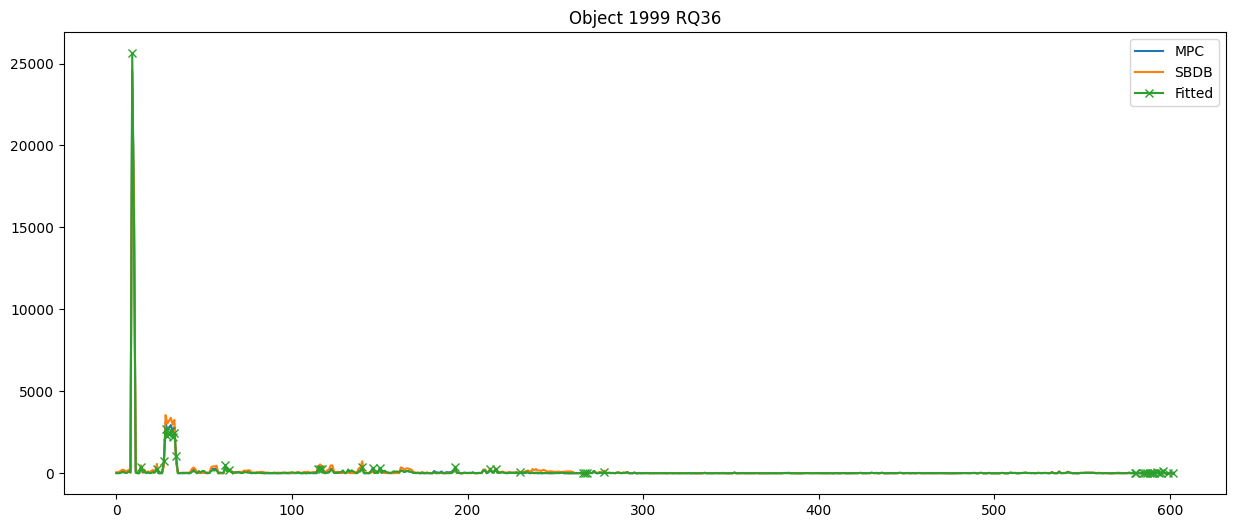

In [5]:
fitter = FindOrbOrbitFitter(fo_result_dir="../fo_dir")

# Fit for one object
object_id = mpc_observations.requested_provid.unique()[0].as_py()
subset = mpc_observations.apply_mask(pc.equal(mpc_observations.requested_provid, object_id))
od_observations = mpc_to_od_observations(subset, prevent_nans=False)
fitted_orbits, fitted_members = fitter.initial_fit(object_id, od_observations)

# Recompute observations without NaNs to run evaluation
od_observations = mpc_to_od_observations(subset, prevent_nans=True)
if len(fitted_orbits) > 0:
    show_for(object_id, od_observations, fitted_orbits, fitted_members, subset.obsid)

In [ ]:
# Fit all objects in one pass
fitted_orbits, fitted_members = fitter.initial_fit_all_objects(mpc_observations)
print(f"Fitted orbits for objects {fitted_orbits.object_id.to_pylist()}")
print(f"Fitted members {fitted_members}")

Skipping object Ceres that has null STNs
Fitted orbits for objects ['1999 RQ36', '2013 RR165']
Fitted members FittedOrbitMembers(size=643)


MPC orbit, object ['2013 RR165'], orbit ['3043703'], rchi2=5.87580158759063
q=2.3570051262264395 e=0.08682375926341278 i=2.7395493639124107
raan=304.7814336515724 ap=23.17967735900581 tp=59492.471025151
time=2022-01-21T00:00:00.000 (59600.0 MJD) period=1514.632643034375 origin=SUN
[[ 2.226e-12  2.503e-27 -1.787e-25 -3.015e-24 -3.263e-24 -7.544e-24]
 [-1.751e-26  2.716e-13 -2.002e-26  2.443e-25 -9.036e-24 -2.595e-23]
 [-2.514e-25  4.560e-26  1.537e-09  5.211e-24  1.114e-23 -1.507e-22]
 [-6.260e-24  1.191e-24  2.726e-24  3.963e-07 -1.042e-21 -9.188e-21]
 [-1.388e-24  3.023e-24  4.400e-23 -3.544e-22  4.195e-07 -1.789e-21]
 [ 1.024e-22 -3.620e-23  9.836e-23 -3.784e-21  5.054e-20  4.085e-07]]
SBDB orbit, object ['(2013 RR165)'], orbit ['00000'], rchi2=9.68431751228424
q=2.3600206054728194 e=0.08548159148666032 i=2.74630476081063
raan=304.8985251739963 ap=22.52191656182098 tp=56461.26216172753
time=2014-11-20T00:00:00.000 (56981.0 MJD) period=1514.2006953392283 origin=SUN
[[ 2.653e-13 -9.175

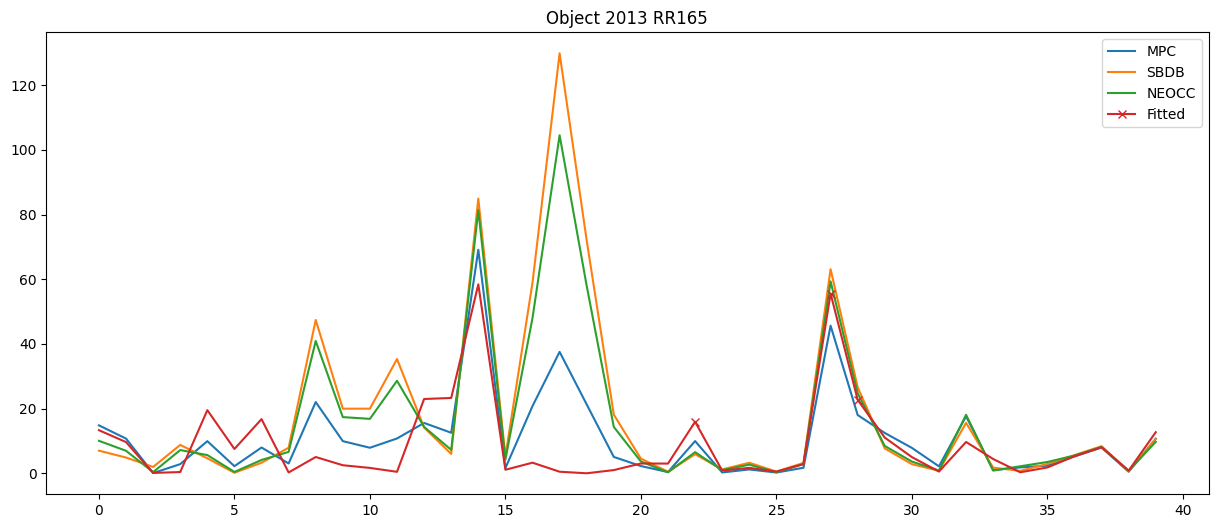

In [7]:
# Pick one object id from all fitted to show
object_id = fitted_orbits.object_id[1].as_py()
subset = mpc_observations.apply_mask(pc.equal(mpc_observations.requested_provid, object_id))
od_observations = mpc_to_od_observations(subset, prevent_nans=True)
show_for(object_id, od_observations, fitted_orbits, fitted_members, subset.obsid)